# The Dataset
### **Brief Description:**

### Problem Statement:
Nigeria struggles with a serious data scarcity issue in healthcare, particularly in my case of exploring the link between obesity and cancer. Without structured and accessible health data, it becomes challenging to develop effective public health policies. This lack of data affects decision-making and research studies like mine.

### About the Data:
To improvise and tackle this gap, I created a synthetic dataset using actual statistics from sources like **PLOS Global Public Health, GLOBOCAN 2022, and the NDHS Report 2018**. The dataset includes:
- **Demographics:** Age, gender, region.
- **Health Indicators:** BMI, blood pressure, cholesterol, blood sugar.
- **Lifestyle Factors:** Physical activity levels, diet quality.
- **Obesity Risk Score:** A calculated metric based on multiple health indicators.

By using probability modeling and Gaussian distributions, the dataset gives realistic patterns reflecting previous Nigeria’s health reports and case studies. It is a bridge for research and analysis in the absence of real data.

### Why This Matters:
This synthetic dataset helps researchers to analyze obesity-related health risks, simulate missing data, and develop models for better health interventions without breaching privacy or waiting for official data collection improvements.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Model
import xgboost as xgb

# Evaluation
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score,
    recall_score, f1_score
)


In [2]:
# File path
file_path = "/content/Nigeria Obesity Risk Synthetic Data - Synthetic_Health_Dataset.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Data Preprocessing
df_processed = df.copy()

In [3]:
df.head()

,Region,Age,Gender,BMI,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Cholesterol,Blood_Sugar,Physical_Activity,Diet_Quality,Obesity_Risk
0,Northeast,54,Male,24.2,107,66,135,65,Moderate,5.4,0.433
1,South-South,48,Female,31.6,126,79,171,101,Low,5.3,0.680
2,Northwest,44,Male,23.9,109,63,133,74,Low,6.3,0.419
3,Northeast,52,Male,18.6,99,60,139,80,Low,6.8,0.303
4,Southwest,42,Female,16.3,99,59,118,60,Low,6.7,0.238


In [4]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['Region', 'Gender', 'Physical_Activity']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for later use

# Define obesity risk categories
def categorize_obesity_risk(value):
    if value < 0.4:
        return 0  # Low Risk
    elif 0.4 <= value <= 0.7:
        return 1  # Medium Risk
    else:
        return 2  # High Risk

df['Obesity_Risk_Category'] = df['Obesity_Risk'].apply(categorize_obesity_risk)
df.drop(columns=['Obesity_Risk'], inplace=True)

# Normalize numerical features
scaler = StandardScaler()
numerical_columns = ['Age', 'BMI', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic', 'Cholesterol', 'Blood_Sugar', 'Diet_Quality']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Split dataset into train, validation, and test sets
X = df.drop(columns=['Obesity_Risk_Category'])
y = df['Obesity_Risk_Category']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Confirm dataset is now available
print("Data loaded successfully!")
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Data loaded successfully!
Training set: (700, 10), (700,)
Validation set: (150, 10), (150,)
Test set: (150, 10), (150,)


In [5]:
# Model Defination

# Define the model function
def define_model(
    optimization: str = 'Adam',
    regularization_method: str = None,
    early_stopping: bool = False,
    dropout: float = 0.0,
    learning_rate: float = 0.001,
    input_dim: int = 10,
    hidden_units: list = [16, 8],
    output_units: int = 3
):
    # Parameter validation
    if dropout < 0 or dropout > 1:
        raise ValueError("Dropout rate must be between 0 and 1")

    if not isinstance(hidden_units, list) or len(hidden_units) < 1:
        raise ValueError("hidden_units must have at least one element")

    if optimization not in ["Adam", "RMSprop"]:
        raise ValueError("Unsupported optimizer. Choose 'Adam' or 'RMSprop'.")

    # Initialize model
    model = Sequential()

    # Input Layer
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(input_dim,)))

    # Hidden Layers with optional regularization
    for units in hidden_units[1:]:
        if regularization_method == "L1":
            model.add(Dense(units, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0)))
        elif regularization_method == "L2":
            model.add(Dense(units, activation='relu', kernel_regularizer=l1_l2(l1=0, l2=0.01)))
        elif regularization_method == "L1_L2":
            model.add(Dense(units, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
        else:
            model.add(Dense(units, activation='relu'))

        # Apply Dropout if specified
        if dropout > 0:
            model.add(Dropout(dropout))

    # Output Layer
    model.add(Dense(output_units, activation='softmax' if output_units > 2 else 'sigmoid'))

    # Select optimizer
    optimizer = Adam(learning_rate=learning_rate) if optimization == "Adam" else RMSprop(learning_rate=learning_rate)

    # Dynamic loss function for multi-class vs binary classification
    loss_function = 'sparse_categorical_crossentropy' if output_units > 2 else 'binary_crossentropy'

    # Compile model
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

    # Setup callbacks
    callbacks = []
    if early_stopping:
        es_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
        callbacks.append(es_callback)

    return model, callbacks

XGBoost Model

In [6]:
!pip install xgboost scikit-learn


In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['actual_column_name'])  # Replace with real column name


In [8]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Defining the XGBoost Model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.01,
    n_estimators=100,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="mlogloss",
    early_stopping_rounds=10
)

# Train the model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Make predictions
y_pred = xgb_model.predict(X_test)
target_names = ['Low', 'Medium', 'High']

# Compute Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class="ovr")
class_report = classification_report(y_test, y_pred, target_names=target_names)

# Print Evaluation Results
print(f"XGBoost Model Performance")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print("\nClassification Report:\n", class_report)

[0]	validation_0-mlogloss:1.08757
[1]	validation_0-mlogloss:1.07621
[2]	validation_0-mlogloss:1.06468
[3]	validation_0-mlogloss:1.05318
[4]	validation_0-mlogloss:1.04195
[5]	validation_0-mlogloss:1.03139
[6]	validation_0-mlogloss:1.02133
[7]	validation_0-mlogloss:1.01192
[8]	validation_0-mlogloss:1.00206
[9]	validation_0-mlogloss:0.99173
[10]	validation_0-mlogloss:0.98232
[11]	validation_0-mlogloss:0.97264
[12]	validation_0-mlogloss:0.96310
[13]	validation_0-mlogloss:0.95384
[14]	validation_0-mlogloss:0.94504
[15]	validation_0-mlogloss:0.93640
[16]	validation_0-mlogloss:0.92750
[17]	validation_0-mlogloss:0.91872
[18]	validation_0-mlogloss:0.91006
[19]	validation_0-mlogloss:0.90111
[20]	validation_0-mlogloss:0.89276
[21]	validation_0-mlogloss:0.88464
[22]	validation_0-mlogloss:0.87660
[23]	validation_0-mlogloss:0.86886
[24]	validation_0-mlogloss:0.86114
[25]	validation_0-mlogloss:0.85320
[26]	validation_0-mlogloss:0.84536
[27]	validation_0-mlogloss:0.83787
[28]	validation_0-mlogloss:0.8

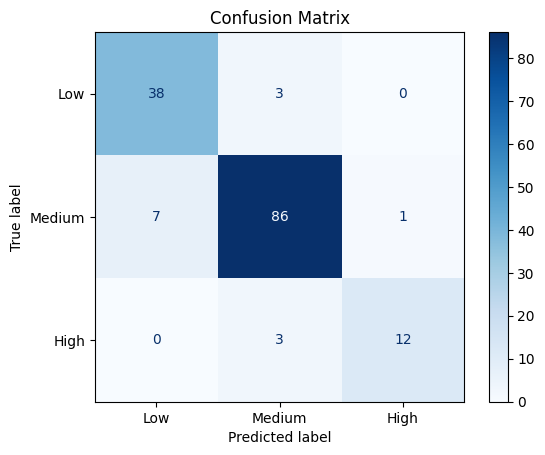

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


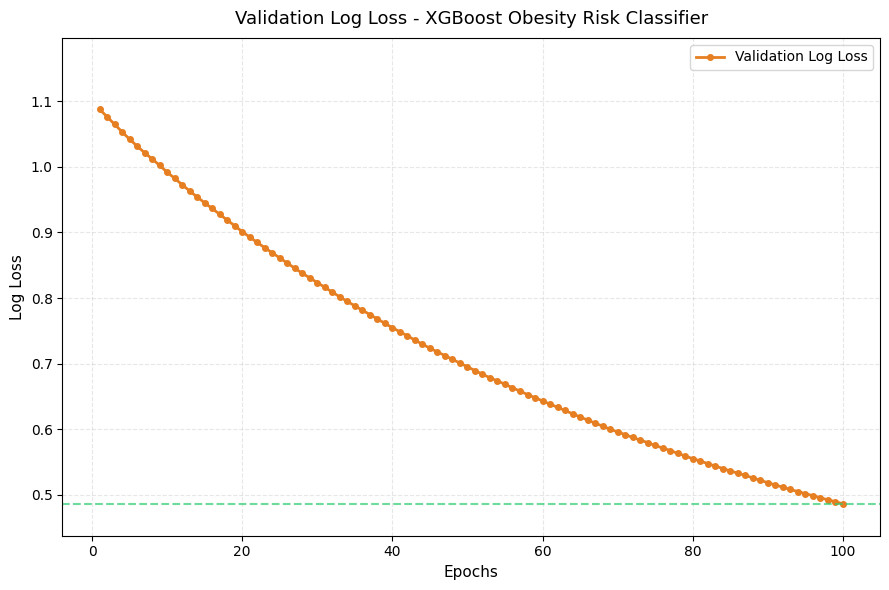

In [15]:
def xgb_loss_curve_plot(loss_values, instance_name="XGBoost"):
    """Plot XGBoost Training Loss (Log Loss) using enhanced styling"""
    epochs = range(1, len(loss_values) + 1)
    plt.figure(figsize=(9, 6))
    plt.plot(epochs, loss_values, 'o-', color='#e67e22', linewidth=2, markersize=4, label='Validation Log Loss')

    min_val_loss = min(loss_values)
    plt.axhline(y=min_val_loss, color='#2ecc71', linestyle='--', alpha=0.7)

    plt.title(f'Validation Log Loss - {instance_name}', fontsize=13, pad=10)
    plt.xlabel('Epochs', fontsize=11)
    plt.ylabel('Log Loss', fontsize=11)
    plt.legend(frameon=True, fancybox=True)
    plt.grid(alpha=0.3, linestyle='--')

    plt.ylim(min(loss_values)*0.9, max(loss_values)*1.1)
    plt.tight_layout()
    plt.show()

# Usage
logloss_values = xgb_model.evals_result()['validation_0']['mlogloss']
xgb_loss_curve_plot(logloss_values, "XGBoost Obesity Risk Classifier")



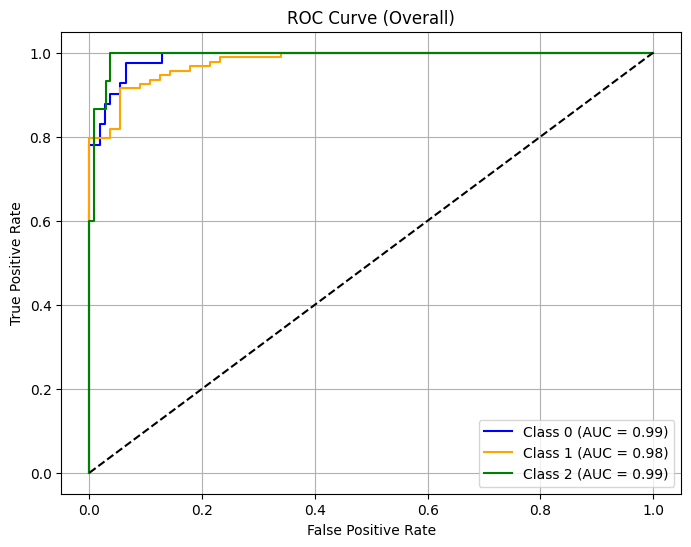

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize true labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_proba = xgb_model.predict_proba(X_test)

# Compute ROC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):  # 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8,6))
colors = ['blue', 'orange', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Overall)')
plt.legend()
plt.grid(True)
plt.show()


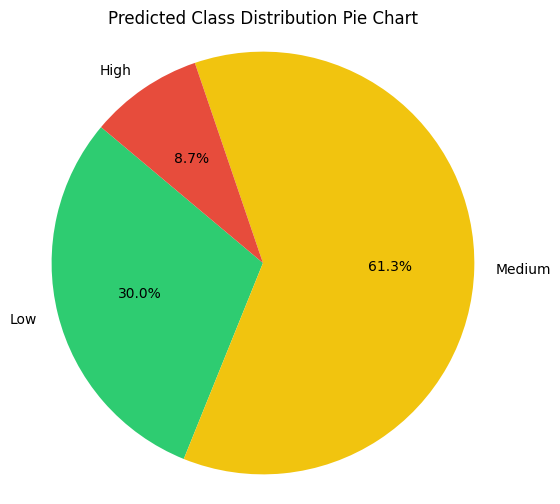

In [18]:
# Count predicted class distribution
pred_counts = pd.Series(y_pred).value_counts().sort_index()

# Map to labels if needed
labels = ['Low', 'Medium', 'High']
colors = ['#2ecc71', '#f1c40f', '#e74c3c']

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(pred_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Predicted Class Distribution Pie Chart")
plt.axis('equal')
plt.show()


In [19]:
# Save model to JSON
xgb_model.save_model("xgb_obesity_model.json")

# Save scaler for deployment
import joblib
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [20]:
%%writefile preprocessing.py
import pandas as pd
import joblib

# Load saved scaler
scaler = joblib.load("scaler.pkl")

# Label encoding values (match training)
label_maps = {
    'Region': {'Urban': 1, 'Rural': 0},
    'Gender': {'Male': 1, 'Female': 0},
    'Physical_Activity': {'Low': 0, 'Moderate': 1, 'High': 2}
}

numerical_columns = ['Age', 'BMI', 'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic', 'Cholesterol', 'Blood_Sugar', 'Diet_Quality']

def preprocess_input(df):
    df = df.copy()

    # Encode categoricals
    for col, mapping in label_maps.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)

    # Scale numeric columns
    df[numerical_columns] = scaler.transform(df[numerical_columns])

    return df


Writing preprocessing.py


In [21]:
%%writefile model.py
import xgboost as xgb

def load_model():
    model = xgb.XGBClassifier()
    model.load_model("xgb_obesity_model.json")
    return model


Writing model.py


In [22]:
%%writefile prediction.py
import pandas as pd
from src.preprocessing import preprocess_input
from src.model import load_model

# Load model
model = load_model()

# Labels
target_names = ['Low', 'Medium', 'High']

def predict_single(data_dict):
    df = pd.DataFrame([data_dict])
    processed = preprocess_input(df)
    prediction = model.predict(processed)[0]
    return target_names[prediction]

def predict_batch(df):
    processed = preprocess_input(df)
    predictions = model.predict(processed)
    return [target_names[pred] for pred in predictions]

Writing prediction.py
